# Tugas 8 - Bagging and Ensemble Learning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn import metrics, model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = "https://raw.githubusercontent.com/febyfadlilah/dataset/main/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(data)

In [ ]:
df.columns = ["ID", "Gender", "Age", "Hypertension", "Heart Disease", "Ever Married", "Work Type", "Residence Type", "Avg. Glucose Level", "BMI", "Smoking Status", "Stroke"]

In [ ]:
#drop ID column
df = df.drop('ID', axis=1)

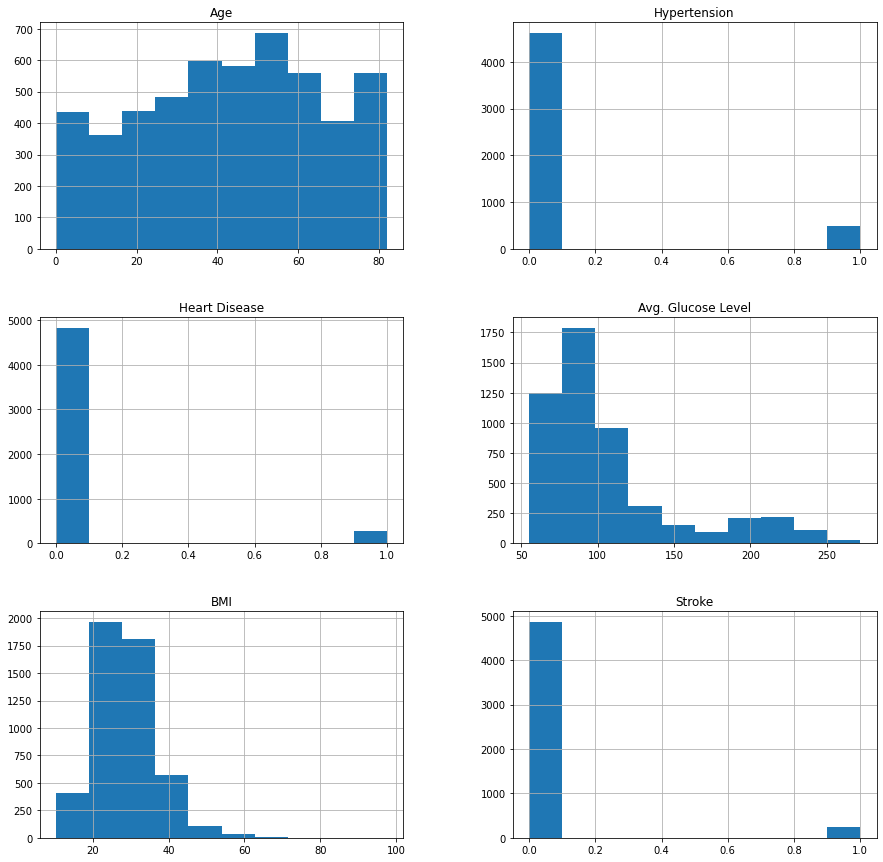

In [ ]:
#plots other feature sets
df.hist(figsize = (15, 15))
plt.show()

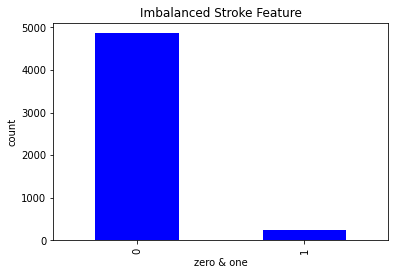

In [ ]:
#plots Stroke feature
df['Stroke'].value_counts(dropna = False).plot.bar(color = 'blue')
plt.title('Imbalanced Stroke Feature')
plt.xlabel('zero & one')
plt.ylabel('count')
plt.show()

In [ ]:
print(df.isnull().sum())
print(df.count())

#removing null values in BMI column
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

Gender                  0
Age                     0
Hypertension            0
Heart Disease           0
Ever Married            0
Work Type               0
Residence Type          0
Avg. Glucose Level      0
BMI                   201
Smoking Status          0
Stroke                  0
dtype: int64
Gender                5110
Age                   5110
Hypertension          5110
Heart Disease         5110
Ever Married          5110
Work Type             5110
Residence Type        5110
Avg. Glucose Level    5110
BMI                   4909
Smoking Status        5110
Stroke                5110
dtype: int64


In [ ]:
print(df.isnull().sum())
print(df.count())

Gender                0
Age                   0
Hypertension          0
Heart Disease         0
Ever Married          0
Work Type             0
Residence Type        0
Avg. Glucose Level    0
BMI                   0
Smoking Status        0
Stroke                0
dtype: int64
Gender                4909
Age                   4909
Hypertension          4909
Heart Disease         4909
Ever Married          4909
Work Type             4909
Residence Type        4909
Avg. Glucose Level    4909
BMI                   4909
Smoking Status        4909
Stroke                4909
dtype: int64


In [ ]:
#transforming dataset with dummies variables to replace characters with binary integers
df["Hypertension"].replace([0,1], ["No","Yes"], inplace=True)
df["Heart Disease"].replace([0,1], ["No","Yes"], inplace=True)

df2 = df[["Gender","Age","Hypertension","Heart Disease","Ever Married","Work Type","Residence Type","Avg. Glucose Level","BMI", "Smoking Status","Stroke"]]

gender = pd.get_dummies(df2["Gender"], drop_first=True)
hypertension = pd.get_dummies(df2["Hypertension"], drop_first=True, prefix="HT")
heartdisease = pd.get_dummies(df2["Heart Disease"], drop_first=True, prefix="HD")
evermarried = pd.get_dummies(df2["Ever Married"], drop_first=True, prefix="EM")
worktype = pd.get_dummies(df2["Work Type"], drop_first=True)
residence = pd.get_dummies(df2["Residence Type"],drop_first=True)
smoking = pd.get_dummies(df2["Smoking Status"], drop_first=True)

df3 = pd.concat([df2,gender,hypertension,heartdisease,evermarried,worktype,residence,smoking], axis=1, join='outer', ignore_index=False)
print(df3.head(15))

    Gender   Age Hypertension Heart Disease Ever Married      Work Type  \
0     Male  67.0           No           Yes          Yes        Private   
1     Male  80.0           No           Yes          Yes        Private   
2   Female  49.0           No            No          Yes        Private   
3   Female  79.0          Yes            No          Yes  Self-employed   
4     Male  81.0           No            No          Yes        Private   
5     Male  74.0          Yes           Yes          Yes        Private   
6   Female  69.0           No            No           No        Private   
7   Female  78.0           No            No          Yes        Private   
8   Female  81.0          Yes            No          Yes        Private   
9   Female  61.0           No           Yes          Yes       Govt_job   
10  Female  54.0           No            No          Yes        Private   
11  Female  79.0           No           Yes          Yes        Private   
12  Female  50.0         

In [ ]:
df3.drop(["Gender","Hypertension","Heart Disease","Ever Married","Work Type", "Residence Type","Smoking Status"], axis=1, inplace=True)

#relabeling dataset with proper headers
df4 = df3.reindex(labels=["Age","Male","HT_Yes","HD_Yes","EM_Yes","Never_worked","Private","Self-employed","children","BMI","Urban","Avg. Glucose Level","formerly smoked", "never smoked", "smokes","Stroke"], axis=1)
print(df4.head(15))

     Age  Male  HT_Yes  HD_Yes  EM_Yes  Never_worked  Private  Self-employed  \
0   67.0     1       0       1       1             0        1              0   
1   80.0     1       0       1       1             0        1              0   
2   49.0     0       0       0       1             0        1              0   
3   79.0     0       1       0       1             0        0              1   
4   81.0     1       0       0       1             0        1              0   
5   74.0     1       1       1       1             0        1              0   
6   69.0     0       0       0       0             0        1              0   
7   78.0     0       0       0       1             0        1              0   
8   81.0     0       1       0       1             0        1              0   
9   61.0     0       0       1       1             0        0              0   
10  54.0     0       0       0       1             0        1              0   
11  79.0     0       0       1       1  

In [ ]:
#feature set
X = df4[["Age","Male","HT_Yes","HD_Yes","EM_Yes","Never_worked","Private","Self-employed","children","BMI","Avg. Glucose Level","formerly smoked", "never smoked", "smokes"]]

#label set
y = df4["Stroke"]

print(X.count())
print(y.count())

Age                   4909
Male                  4909
HT_Yes                4909
HD_Yes                4909
EM_Yes                4909
Never_worked          4909
Private               4909
Self-employed         4909
children              4909
BMI                   4909
Avg. Glucose Level    4909
formerly smoked       4909
never smoked          4909
smokes                4909
dtype: int64
4909


In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (3436, 14)
Number transactions y_train dataset:  (3436,)
Number transactions X_test dataset:  (1473, 14)
Number transactions y_test dataset:  (1473,)


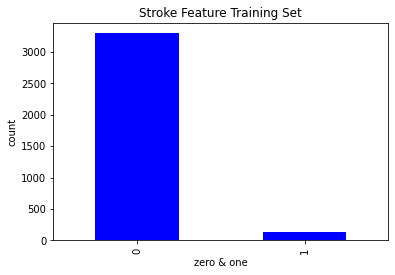

In [ ]:
y_train.value_counts(dropna = False).plot.bar(color = 'blue')
plt.title('Stroke Feature Training Set')
plt.xlabel('zero & one')
plt.ylabel('count')
plt.show()

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 137
Before OverSampling, counts of label '0': 3299 



In [ ]:
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (6598, 14)
After OverSampling, the shape of train_y: (6598,) 

After OverSampling, counts of label '1': 3299
After OverSampling, counts of label '0': 3299


In [ ]:
#Gaussian naive bayes model
clf = GaussianNB()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy Score Gaussian = ", accuracy_score(y_test, y_pred))

Accuracy Score Gaussian =  0.3448744059742023


In [ ]:
seed = 42
kfold = model_selection.KFold(n_splits = 3,random_state = seed,shuffle=True)
  
# initialize the base classifier
base_cls = DecisionTreeClassifier()
  
# no. of base classifier
# #Total Number of decision trees that will be used to train an ensemble
num_trees = 100

In [ ]:
# bagging classifier
model = BaggingClassifier(base_estimator = base_cls,            # base estimator to fit on random subsets of the datraset
                            n_estimators = num_trees,           # number of base estimators in the ensemble
                            max_samples=50,                     # the number of features to draw from X to train each base estimator
                            bootstrap = True,                   # Bootstrap = True means use bagging method
                            random_state = seed)

In [ ]:
results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold)

print("Bagging Accuracy Score:\t", results.mean())

Bagging Accuracy Score:	 0.7975171910096877
